# Permutation Importance and Ensemble Experiments in Fastai Tabular For Homesite Competition
> Here I borrow generously from [Zach's notebook](https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Tabular%20Notebooks/02_Ensembling.ipynb)
- toc: true to apply his techniques for permutation importance and ensemble learning to the Homesite Competition problem set
- badges: true
- comments: true
- categories: [kaggle, fastai]
- author: Nissan Dookeran
- image: images/chart-preview.png

## Introduction
Learning from WalkWithFastai's lesson on permutation importance and ensemble techniques we apply some of it to the homesite competition data

Notes:
- Changed the categorize functions from [last notebook](https://redditech.github.io/team-fast-tabulous/kaggle/fastai/2021/06/27/Improving-Fastai-split-choices.html) to exclude any columns in y_names from being evaluated since these shouldn't be part of the model training as a parameter

## Setup

In [1]:
!pip install -Uqq fastai

In [2]:
!pip install kaggle

In [3]:
from fastai.tabular.all import *
from kaggle import api

In [4]:
Path.cwd()

Path('/mnt/d/Code/GitHub/team-fast-tabulous/_notebooks')

In [5]:
!touch .gitignore

In [6]:
!echo "_data" > .gitignore

In [7]:
!mkdir _data

mkdir: cannot create directory ‘_data’: File exists


In [8]:
os.chdir('_data')
Path.cwd()

Path('/mnt/d/Code/GitHub/team-fast-tabulous/_notebooks/_data')

In [9]:
path = Path.cwd()/"homesite_competition_data"
path.mkdir(exist_ok=True)
Path.BASE_PATH = path
api.competition_download_cli('homesite-quote-conversion', path=path)
file_extract(path/"homesite-quote-conversion.zip")
file_extract(path/"train.csv.zip")
file_extract(path/"test.csv.zip")
path.ls()

homesite-quote-conversion.zip: Skipping, found more recently modified local copy (use --force to force download)


(#6) [Path('homesite-quote-conversion.zip'),Path('sample_submission.csv.zip'),Path('test.csv'),Path('test.csv.zip'),Path('train.csv'),Path('train.csv.zip')]

### Set my parameter defaults (may change)

In [94]:
random_seed = 42 
bs = 4096
val_bs = 512
test_size = 0.3
epochs = 3
lr = 1e-2
wd=0.002
layers = [10000,500]
dropout = [0.001, 0.01]
y_block=CategoryBlock()
emb_dropout=0.02
set_seed(42)

In [11]:
df_train = pd.read_csv(path/"train.csv", low_memory=False)
df_train.head(2)

,QuoteNumber,Original_Quote_Date,QuoteConversion_Flag,Field6,Field7,Field8,Field9,Field10,Field11,Field12,...,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,1,2013-08-16,0,B,23,0.9403,0.0006,965,1.0200,N,...,9,9,-1,8,-1,18,-1,10,N,CA
1,2,2014-04-22,0,F,7,1.0006,0.0040,548,1.2433,N,...,10,10,-1,11,-1,17,-1,20,N,NJ


In [12]:
df_train.shape

(260753, 299)

In [13]:
df_test = pd.read_csv(path/"test.csv", low_memory=False)
df_test.head(2)

,QuoteNumber,Original_Quote_Date,Field6,Field7,Field8,Field9,Field10,Field11,Field12,CoverageField1A,...,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,3,2014-08-12,E,16,0.9364,0.0006,"1,487",1.3045,N,4,...,1,1,-1,1,-1,20,-1,25,Y,IL
1,5,2013-09-07,F,11,0.9919,0.0038,564,1.1886,N,8,...,10,10,-1,5,-1,5,-1,21,N,NJ


In [14]:
df_test.shape

(173836, 298)

In [15]:
y_column = df_train.columns.difference(df_test.columns)
y_column

Index(['QuoteConversion_Flag'], dtype='object')

In [16]:
df_train.QuoteConversion_Flag = df_train.QuoteConversion_Flag.astype(dtype='boolean')

In [17]:
train_data_balance = pd.DataFrame(df_train["QuoteConversion_Flag"]).groupby("QuoteConversion_Flag")
train_data_balance["QuoteConversion_Flag"].describe()

,count,unique,top,freq
QuoteConversion_Flag,,,,
False,211859,1,False,211859
True,48894,1,True,48894


Adding [Tim's bits of insight](https://redditech.github.io/team-fast-tabulous/jupyter/2021/06/20/Identify-problem-type.html)

In [18]:
df_train = df_train.set_index('QuoteNumber')
df_test = df_test.set_index('QuoteNumber')

In [19]:
df_train['Original_Quote_Date'] = pd.to_datetime(df_train['Original_Quote_Date'])
df_test['Original_Quote_Date'] = pd.to_datetime(df_test['Original_Quote_Date'])
df_train = add_datepart(df_train, 'Original_Quote_Date')
df_test = add_datepart(df_test, 'Original_Quote_Date')

In [20]:
y_names = [y_column[0]]
cont_names, cat_names = cont_cat_split(df_train, dep_var=y_names)
len(cont_names), len(cat_names)

(155, 154)

In [21]:
triage = L()

In [22]:
def reassign_to_categorical(field, df, y_names, continuous, categorical, triage):
  if ((df[field].isna().sum()==0) and (field not in y_names)):
    field_categories = df[field].unique()
    df[field] = df[field].astype('category')
    df[field].cat.set_categories(field_categories, inplace=True)
    if field in continuous: continuous.remove(field)
    if field not in categorical: categorical.append(field)
  else:
    if field in continuous: continuous.remove(field)
    if field in categorical: categorical.remove(field)
    triage.append(field)

  return df, continuous, categorical, triage

In [23]:
def categorize( df, y_names, cont_names, cat_names, triage, category_threshold):
  for field in df.columns:
    if ((len(df[field].unique()) <= category_threshold) and (type(df[field].dtype) != pd.core.dtypes.dtypes.CategoricalDtype)):
      reassign_to_categorical(field, df, y_names, cont_names, cat_names, triage)
  return df, cont_names, cat_names, triage

In [24]:
df_train, cont_names, cat_names, triage = categorize(df_train, y_names, cont_names, cat_names, triage, 100)

In [25]:
"QuoteConversion_Flag" in cont_names, "QuoteConversion_Flag" in cat_names #Make sure we've gotten our y-column excluded

(False, False)

In [78]:
procs = [Categorify, FillMissing, Normalize]
splits = TrainTestSplitter(test_size=test_size, stratify=df_train[y_names])(df_train)

In [79]:
# splits = RandomSplitter(seed=random_seed)(df_train) # Can try results with this afterwards to see if more/less effective

In [95]:
to = TabularPandas(df=df_train, procs=procs, cat_names=cat_names, 
                   cont_names=cont_names, y_names=y_names,splits=splits,
                  y_block=y_block)
dls = to.dataloaders(bs=bs, val_bs=val_bs, layers=layers, embed_ps=emb_dropout, ps=dropout)
dls.valid.show_batch()

,Field6,Field10,Field12,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,SalesField3,SalesField4,SalesField5,SalesField7,SalesField9,SalesField10,SalesField11,SalesField13,SalesField14,SalesField15,PersonalField1,PersonalField2,PersonalField5,PersonalField6,PersonalField8,PersonalField9,PersonalField11,PersonalField12,PersonalField13,PersonalField16,PersonalField17,PersonalField18,PersonalField19,PersonalField22,PersonalField23,PersonalField24,PersonalField25,PersonalField26,PersonalField27,PersonalField28,PersonalField29,PersonalField30,PersonalField31,PersonalField32,PersonalField33,PersonalField34,PersonalField35,PersonalField36,PersonalField37,PersonalField38,PersonalField39,PersonalField40,PersonalField41,PersonalField42,PersonalField43,PersonalField44,PersonalField45,PersonalField46,PersonalField47,PersonalField48,PersonalField49,PersonalField50,PersonalField51,PersonalField52,PersonalField53,PersonalField54,PersonalField55,PersonalField56,PersonalField57,PersonalField58,PersonalField59,PersonalField60,PersonalField61,PersonalField62,PersonalField63,PersonalField64,PersonalField65,PersonalField66,PersonalField67,PersonalField68,PersonalField69,PersonalField70,PersonalField71,PersonalField72,PersonalField73,PersonalField74,PersonalField75,PersonalField76,PersonalField77,PersonalField78,PersonalField79,PersonalField80,PersonalField81,PersonalField82,PersonalField83,PropertyField2A,PropertyField5,PropertyField6,PropertyField7,PropertyField8,PropertyField9,PropertyField10,PropertyField11A,PropertyField11B,PropertyField12,PropertyField13,PropertyField14,PropertyField15,PropertyField17,PropertyField18,PropertyField19,PropertyField20,PropertyField22,PropertyField23,PropertyField27,PropertyField28,PropertyField30,PropertyField31,PropertyField33,PropertyField35,PropertyField37,GeographicField5A,GeographicField5B,GeographicField10A,GeographicField10B,GeographicField14A,GeographicField14B,GeographicField18A,GeographicField21A,GeographicField22A,GeographicField22B,GeographicField23A,GeographicField56A,GeographicField60A,GeographicField61A,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64,Original_Quote_Year,Original_Quote_Month,Original_Quote_Dayofweek,Original_Quote_Is_month_end,Original_Quote_Is_month_start,Original_Quote_Is_quarter_end,Original_Quote_Is_quarter_start,Original_Quote_Is_year_end,Original_Quote_Is_year_start,Field7,Field8,Field9,Field11,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField6,SalesField12,PersonalField4A,PersonalField4B,PersonalField10A,PersonalField10B,PersonalField14,PersonalField15,PropertyField1A,PropertyField1B,PropertyField2B,PropertyField16A,PropertyField16B,PropertyField21A,PropertyField21B,PropertyField24A,PropertyField24B,PropertyField25,PropertyField26A,PropertyField26B,PropertyField39A,PropertyField39B,GeographicField1A,GeographicField1B,GeographicField2A,GeographicField2B,GeographicField3A,GeographicField3B,GeographicField4A,GeographicField4B,GeographicField6A,GeographicField6B,GeographicField7A,GeographicField7B,GeographicField8A,GeographicField8B,GeographicField9A,GeographicField9B,GeographicField11A,GeographicField11B,GeographicField12A,GeographicField12B,GeographicField13A,GeographicField13B,GeographicField15A,GeographicField15B,GeographicField16A,GeographicField16B,GeographicField17A,GeographicField17B,GeographicField18B,GeographicField19A,GeographicField19B,GeographicField20A,GeographicField20B,GeographicField21B,GeographicField23B,GeographicField24A,GeographicField24B,GeographicField25A,GeographicField25B,GeographicField26A,GeographicField26B,GeographicField27A,GeographicField27B,GeographicField28A,GeographicField28B,GeographicField29A,GeographicField29B,GeographicField30A,GeographicField30B,GeographicField31A,GeographicField31B,GeographicField32

In [96]:
learn = tabular_learner(dls, metrics=accuracy)

In [97]:
#learn.summary()

SuggestedLRs(valley=tensor(0.0008), slide=tensor(0.0229), minimum=0.06309573650360108, steep=0.013182567432522774)

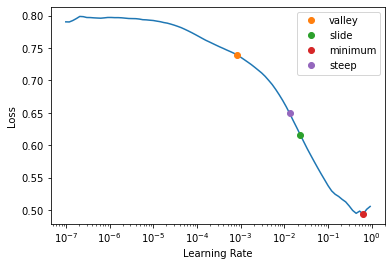

In [98]:
learn.lr_find(suggest_funcs=(valley, slide, minimum, steep))

In [99]:
learn.fit_one_cycle(epochs,lr, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.342952,0.215471,0.909276,00:15
1,0.227020,0.178934,0.922762,00:15
2,0.184288,0.179401,0.922698,00:14


In [116]:
preds, targs = learn.get_preds()

In [117]:
accuracy(preds,targs)

TensorBase(0.9227)

In [125]:
class PermutationImportance():
  "Calculate and plot the permutation importance"
  def __init__(self, learn:Learner, df=None, bs=None):
    "Initialize with a test dataframe, a learner, and a metric"
    self.learn = learn
    self.df = df if df is not None else None
    bs = bs if bs is not None else learn.dls.bs
    self.dl = learn.dls.test_dl(self.df, bs=bs) if self.df is not None else learn.dls[1]
    self.x_names = learn.dls.x_names.filter(lambda x: '_na' not in x)
    self.na = learn.dls.x_names.filter(lambda x: '_na' in x)
    self.y = dls.y_names
    self.results = self.calc_feat_importance()
    self.plot_importance(self.ord_dic_to_df(self.results))

  def measure_col(self, name:str):
    "Measures change after column shuffle"
    col = [name]
    if f'{name}_na' in self.na: col.append(name)
    orig = self.dl.items[col].values
    perm = np.random.permutation(len(orig))
    self.dl.items[col] = self.dl.items[col].values[perm]
    metric = learn.validate(dl=self.dl)[1]
    self.dl.items[col] = orig
    return metric

  def calc_feat_importance(self):
    "Calculates permutation importance by shuffling a column on a percentage scale"
    print('Getting base error')
    base_error = self.learn.validate(dl=self.dl)[1]
    self.importance = {}
    pbar = progress_bar(self.x_names)
    print('Calculating Permutation Importance')
    for col in pbar:
      self.importance[col] = self.measure_col(col)
    for key, value in self.importance.items():
      self.importance[key] = (base_error-value)/base_error #this can be adjusted
    return OrderedDict(sorted(self.importance.items(), key=lambda kv: kv[1], reverse=True))

  def ord_dic_to_df(self, dict:OrderedDict):
    return pd.DataFrame([[k, v] for k, v in dict.items()], columns=['feature', 'importance'])

  def plot_importance(self, df:pd.DataFrame, limit=20, asc=False, **kwargs):
    "Plot importance with an optional limit to how many variables shown"
    df_copy = df.copy()
    df_copy['feature'] = df_copy['feature'].str.slice(0,25)
    df_copy = df_copy.sort_values(by='importance', ascending=asc)[:limit].sort_values(by='importance', ascending=not(asc))
    ax = df_copy.plot.barh(x='feature', y='importance', sort_columns=True, **kwargs)
    for p in ax.patches:
      ax.annotate(f'{p.get_width():.4f}', ((p.get_width() * 1.005), p.get_y()  * 1.005))

Getting base error


Calculating Permutation Importance


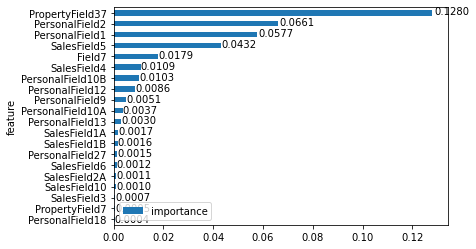

In [126]:
imp = PermutationImportance(learn)

From this most important fields are `PropertyField37`, `PersonalField2`, `PersonalField1`, `SalesField5`

## Adding in XGBoost

In [101]:
import xgboost as xgb

In [111]:
n_estimators = 100
max_depth = 8
learning_rate = 0.1
subsample = 0.5

In [102]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_valid, y_valid = to.valid.xs, to.valid.ys.values.ravel()

In [109]:
model = xgb.XGBClassifier(n_estimators = n_estimators, max_depth=max_depth, learning_rate=0.1, subsample=subsample)

In [110]:
xgb_model = model.fit(X_train, y_train)

[22:49:10] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [113]:
xgb_preds = xgb_model.predict_proba(X_valid)

In [114]:
xgb_preds

array([[0.96717715, 0.03282287],
       [0.96896064, 0.03103935],
       [0.00723386, 0.99276614],
       ...,
       [0.87994975, 0.12005027],
       [0.00716239, 0.9928376 ],
       [0.90019906, 0.09980095]], dtype=float32)

In [115]:
accuracy(tensor(xgb_preds), tensor(y_valid))

TensorBase(0.9237)

In [118]:
from xgboost import plot_importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

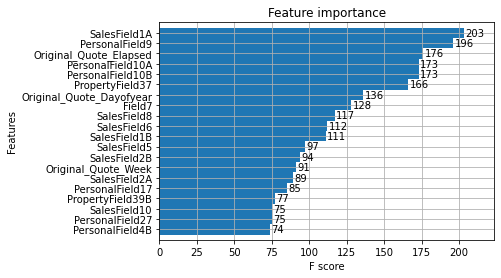

In [124]:
plot_importance(xgb_model, height=1,max_num_features=20,)

From this most important fields were `SalesField1A`, `PersonalField9`, `Original_Quote_Elapsed`, `PersonalField10A`, `PersonalField10B`, `PropertyField37`

## Doing Ensemble

In [129]:
avgs = (preds + xgb_preds) / 2

In [130]:
avgs

tensor([[0.9761, 0.0239],
        [0.9612, 0.0388],
        [0.0040, 0.9960],
        ...,
        [0.9249, 0.0751],
        [0.0036, 0.9964],
        [0.9015, 0.0985]])

In [131]:
argmax = avgs.argmax(dim=1)

In [132]:
argmax

tensor([0, 0, 1,  ..., 0, 1, 0])

In [133]:
y_valid

array([0, 0, 1, ..., 0, 1, 0], dtype=int8)

In [135]:
accuracy(tensor(preds), tensor(y_valid))

TensorBase(0.9227)

In [137]:
accuracy(tensor(xgb_preds), tensor(y_valid))

TensorBase(0.9237)

In [138]:
accuracy(tensor(avgs), tensor(y_valid))

TensorBase(0.9246)

So we have a slightly better performance with ensembling these two

## Adding Random Forest

In [139]:
from sklearn.ensemble import RandomForestClassifier

In [140]:
tree = RandomForestClassifier(n_estimators=100)

In [141]:
tree.fit(X_train, y_train)

RandomForestClassifier()

In [142]:
!pip install rfpimp

  Created wheel for rfpimp: filename=rfpimp-1.3.7-py3-none-any.whl size=10668 sha256=34224b08f42a6e9b6ed748abc732400eaff9bf484bb215a1f3b6fea8cabd1d49
  Stored in directory: /home/nissan/.cache/pip/wheels/d9/f2/53/6d8c73011f73fc347598d683ff8b2343605ad43474ae083816
Successfully built rfpimp


In [144]:
from rfpimp import *

In [150]:
impTree = importances(tree, X_valid, to.valid.ys)

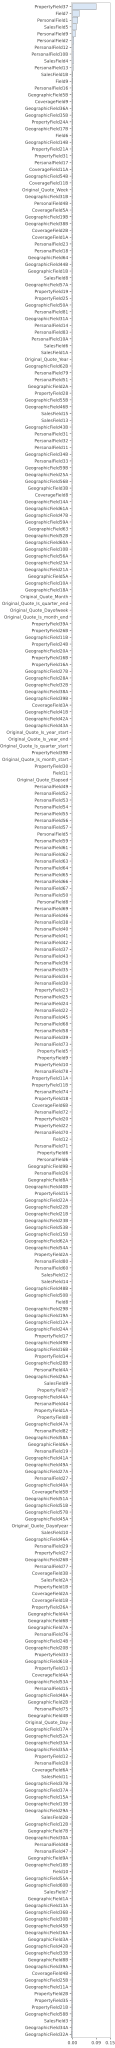

In [157]:
plot_importances(impTree)

So here the most important are `PropertyField37`, `Field7`,`PersonalField1`, `SalesField5`, `PersonalField9`,`PersonalField2`

In [151]:
forest_preds = tree.predict_proba(X_valid)

In [152]:
forest_preds

array([[0.95, 0.05],
       [0.91, 0.09],
       [0.32, 0.68],
       ...,
       [0.85, 0.15],
       [0.34, 0.66],
       [0.88, 0.12]])

In [158]:
accuracy(tensor(forest_preds), tensor(y_valid))

TensorBase(0.9152)

In [153]:
new_avgs =  (preds + xgb_preds + forest_preds) / 3

In [154]:
accuracy(tensor(new_avgs), tensor(y_valid))

TensorBase(0.9242)

So it gets slightly worse when we add Random Forest to the ensemble. 
> Next step will be to apply the models to the test set from Kaggle and try submissions to see how they score